# Purpose

Compare the learnability of GO terms from composition-induced co-expression across manually curated tissue categories

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm

### Load GO term performance from composition-induced co-expression

In [8]:
def load_learnability(path:str)->pd.DataFrame:
	"""Load a dataframe containing info about a GO term's learnability from composition-induced co-expression

	Args:
		path (str): file path

	Returns:
		pd.DataFrame: df
	"""
	GO_learnabilty_df = pd.read_csv(path,index_col=0)

	# extract and drop some metadata columns
	GO_learnabilty_df['exp_type'] = GO_learnabilty_df.organism_part.str.split("_").str.get(0)
	GO_learnabilty_df['tissue'] = GO_learnabilty_df.organism_part.str.split("_").str.get(1)
	GO_learnabilty_df = GO_learnabilty_df[GO_learnabilty_df.loc[:,'variance']==0.05]
	GO_learnabilty_df.drop('organism_part', axis =1 , inplace=True)
	GO_learnabilty_df.drop('variance', axis =1 , inplace=True)

	return GO_learnabilty_df
	
path_to_learnability_file = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run_feb29/master_melted_df.csv.gz"
GO_learnabilty_df = load_learnability(path_to_learnability_file)
GO_learnabilty_df.head()

,index,bootstrap,auc,exp_type,tissue
1397,GO:0000045,3,0.522443,cntrl,brain
1398,GO:0000070,3,0.504677,cntrl,brain
1399,GO:0000077,3,0.468358,cntrl,brain
1400,GO:0000079,3,0.498369,cntrl,brain
1401,GO:0000082,3,0.520443,cntrl,brain


### Load tissue-categories of GO terms

In [9]:
def load_GO_curations(patho_to_curations="/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv"):
	GO_curations = pd.read_csv(patho_to_curations, sep = "\t")

	def melt_curations(df:pd.DataFrame)->pd.DataFrame:
		"""
		create a new column that is a melted version of the GO term curations

		Parameters:
		- df: pandas DataFrame

		Returns:
		- pandas DataFrame with a new column 'meta' indicating the curation category of the GO term
		"""
		# Create a new column using conditions
		meta = df.apply(lambda row: 'Brain' if row['BrainAffiliated'] == 'T' else ('PBMC' if row['PBMCAffiliated'] == 'T' else "Neither"), axis=1)
		df['meta']=meta
		
		return df
	GO_curations = melt_curations(GO_curations)
	return GO_curations

GO_curations = load_GO_curations()

In [10]:
# Merge GO learnability with curated category
GO_learnabilty_df = GO_learnabilty_df.merge(GO_curations.loc[:,['id','meta']], left_on='index', right_on='id')

#  Calc mean for graphing convenience and reduce overplotting
GO_learnabilty_df_mean = GO_learnabilty_df.groupby(['index', 'exp_type', 'tissue','meta'])['auc'].mean().reset_index()

### Plot relationship

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to T

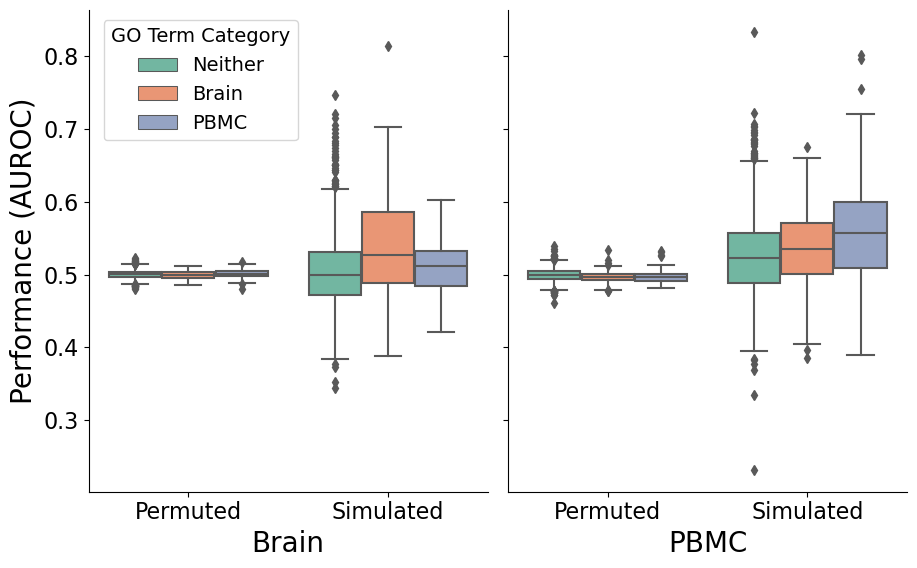

In [11]:
def plot(GO_learnabilty_df_mean)->None:
    # Set the color palette
    sns.set_palette('Set2')  # Set the color palette to Dark

    GO_learnabilty_df_mean['exp_type'] = pd.Categorical(GO_learnabilty_df_mean.loc[:,'exp_type'], categories=['cntrl', 'exp'], ordered=True)
    GO_learnabilty_df_mean['meta'] = pd.Categorical(GO_learnabilty_df_mean.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)

    # Create a FacetGrid with seaborn
    g = sns.FacetGrid(GO_learnabilty_df_mean, col="tissue", height=6, aspect=0.75)

    # Draw a boxplot in each facet
    g.map(sns.boxplot, 'exp_type', 'auc', 'meta', palette="Set2")

    # Set the background color to white
    plt.gca().set_facecolor('white')

    # Remove facet titles
    g.set_titles("")

    # Set x-axis labels with smaller font size separately for each column
    g.axes[0, 0].set_xlabel('Brain', fontsize=20)
    g.axes[0, 1].set_xlabel('PBMC', fontsize=20)

    # Set y-axis label with smaller font size
    g.set_ylabels("Performance (AUROC)", fontsize=20)

    # Add a legend with a custom title and font size
    legend = plt.legend(title="GO Term Category", fontsize=14, bbox_to_anchor=(-0.5,1))

    # Set the font size of the legend title
    legend.get_title().set_fontsize(14)

    # Rename the legend labels
    legend.get_texts()[0].set_text("Neither")
    legend.get_texts()[1].set_text("Brain")
    legend.get_texts()[2].set_text("PBMC")

    # Access each axis and set custom tick labels
    for ax in g.axes.flat:
        ax.set_xticklabels(["Permuted", "Simulated"], fontsize=16)
        ax.tick_params(axis='y', labelsize=16) 
    # Adjust the layout to make room for the title
    g.fig.subplots_adjust(top=0.9)

    # Add a title to the entire plot
    # g.fig.suptitle('Simulated Bulk from Cell Type Profiles', fontsize=16)
    # Add a title to the entire plot
    # g.fig.suptitle('       Composition Variance Increases \n       Performance of Cell Type Related GO Terms', fontsize=20,  y=1.025)


    # Save the plot
    g.savefig('figs/CTProfileBulkResults.png', dpi = 300)

plot(GO_learnabilty_df_mean)

### Evaluate Differences

In [21]:
def print_mixedlm(GO_learnabilty_df:pd.DataFrame)->None:
	print("~~~Mixed Effect Model~~~~~")
	GO_learnabilty_df['meta'] = pd.Categorical(GO_learnabilty_df.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)
	model = mixedlm("auc ~ exp_type * meta", GO_learnabilty_df, groups=GO_learnabilty_df["id"])
	result = model.fit()
	print(result.summary())
	# anova_table = sm.stats.anova_lm(model, typ=2)
	# print(anova_table)
	# print('\n\n')
	# print("~~~~~TUKEYHSD~~~~~")
	# tukey = pairwise_tukeyhsd(endog=GO_curations[ycol], groups=GO_curations['meta'], alpha=0.01)
	# print(tukey.summary())
	# print(tukey.pvalues)

print("Brain Mixed Effect Model")
GO_learnabilty_df_brain = GO_learnabilty_df[GO_learnabilty_df.loc[:,'tissue']=="brain"]
print_mixedlm(GO_learnabilty_df=GO_learnabilty_df_brain)

Brain Mixed Effect Model
~~~Mixed Effect Model~~~~~


/tmp/ipykernel_3308416/1762091544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_learnabilty_df['meta'] = pd.Categorical(GO_learnabilty_df.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      auc        
No. Observations:       279200       Method:                  REML       
No. Groups:             1396         Scale:                   0.0028     
Min. group size:        200          Log-Likelihood:          421740.1066
Max. group size:        200          Converged:               Yes        
Mean group size:        200.0                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      0.501    0.001 653.886 0.000  0.499  0.502
exp_type[T.exp]                0.004    0.000  20.300 0.000  0.004  0.005
meta[T.Brain]                 -0.001    0.003  -0.366 0.715 -0.006  0.004
meta[T.PBMC]                   0.001    0.002   0.358 0.

/tmp/ipykernel_3308416/1762091544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_learnabilty_df['meta'] = pd.Categorical(GO_learnabilty_df.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/base/model.py:6

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      auc        
No. Observations:       279200       Method:                  REML       
No. Groups:             1396         Scale:                   0.0041     
Min. group size:        200          Log-Likelihood:          368749.5783
Max. group size:        200          Converged:               No         
Mean group size:        200.0                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      0.499    0.001 508.994 0.000  0.497  0.501
exp_type[T.exp]                0.026    0.000  97.824 0.000  0.025  0.026
meta[T.Brain]                 -0.003    0.003  -0.790 0.430 -0.010  0.004
meta[T.PBMC]                  -0.002    0.003  -0.628 0.

In [22]:
print("PBMC Mixed Effect Model")
GO_learnabilty_df_pbmc = GO_learnabilty_df[GO_learnabilty_df.loc[:,'tissue']=="pbmc"]
print_mixedlm(GO_learnabilty_df=GO_learnabilty_df_pbmc)

PBMC Mixed Effect Model
~~~Mixed Effect Model~~~~~


/tmp/ipykernel_3308416/1762091544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_learnabilty_df['meta'] = pd.Categorical(GO_learnabilty_df.loc[:,'meta'], categories=['Neither', 'Brain', 'PBMC'], ordered=True)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/base/model.py:6

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      auc        
No. Observations:       279200       Method:                  REML       
No. Groups:             1396         Scale:                   0.0041     
Min. group size:        200          Log-Likelihood:          368749.5783
Max. group size:        200          Converged:               No         
Mean group size:        200.0                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      0.499    0.001 508.994 0.000  0.497  0.501
exp_type[T.exp]                0.026    0.000  97.824 0.000  0.025  0.026
meta[T.Brain]                 -0.003    0.003  -0.790 0.430 -0.010  0.004
meta[T.PBMC]                  -0.002    0.003  -0.628 0.